### Pretraining on Wiki-text

We use
the AWD-LSTM language model (Merity et al.,
2017a) with an embedding size of 400, 3 layers,
1150 hidden activations per layer, and a BPTT
batch size of 70.

https://arxiv.org/pdf/1801.06146.pdf

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
import warnings
warnings.filterwarnings('ignore')

In [3]:
#!conda install seaborn -y

In [4]:
#export
from lib.nb_06 import *
import seaborn as sns

In [5]:
path = datasets.Config().data_path()
version = '103' #2

In [6]:
path

PosixPath('/home/paperspace/.fastai/data')

### Data

In [7]:
#! wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-{version}-v1.zip -P {path}

In [8]:
# ! unzip -q -n {path}/wikitext-{version}-v1.zip  -d {path}
# ! mv {path}/wikitext-{version}/wiki.train.tokens {path}/wikitext-{version}/train.txt
# ! mv {path}/wikitext-{version}/wiki.valid.tokens {path}/wikitext-{version}/valid.txt
# ! mv {path}/wikitext-{version}/wiki.test.tokens {path}/wikitext-{version}/test.txt

In [9]:
path = datasets.Config().data_path()/'wikitext-103'

In [10]:
path.ls()

[PosixPath('/home/paperspace/.fastai/data/wikitext-103/pretrained_lm.zip'),
 PosixPath('/home/paperspace/.fastai/data/wikitext-103/vocab.pkl'),
 PosixPath('/home/paperspace/.fastai/data/wikitext-103/pretrained.pth'),
 PosixPath('/home/paperspace/.fastai/data/wikitext-103/train.txt'),
 PosixPath('/home/paperspace/.fastai/data/wikitext-103/valid.txt'),
 PosixPath('/home/paperspace/.fastai/data/wikitext-103/ll_wiki.pkl'),
 PosixPath('/home/paperspace/.fastai/data/wikitext-103/test.txt')]

In [11]:
def istitle(line):
    return len(re.findall(r'^ = [^=]* = $', line)) != 0

In [12]:
def read_wiki(filename):
    articles = []
    with open(filename, encoding='utf8') as f:
        lines = f.readlines()
    current_article = ''
    for i,line in enumerate(lines):
        current_article += line
        if i < len(lines)-2 and lines[i+1] == ' \n' and istitle(lines[i+2]):
            current_article = current_article.replace('<unk>', UNK)
            articles.append(current_article)
            current_article = ''
    current_article = current_article.replace('<unk>', UNK)
    articles.append(current_article)
    return articles

In [13]:
t = read_wiki(path/'train.txt')

In [14]:
len(t)

18417

In [15]:
t[0]

' \n = Valkyria Chronicles III = \n \n Senjō no Valkyria 3 : xxunk Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " xxunk Raven " . \n The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series new

In [16]:
t[1]

' \n = Tower Building of the Little Rock Arsenal = \n \n The Tower Building of the Little Rock Arsenal , also known as U.S. Arsenal Building , is a building located in MacArthur Park in downtown Little Rock , Arkansas . Built in 1840 , it was part of Little Rock \'s first military installation . Since its decommissioning , The Tower Building has housed two museums . It was home to the Arkansas Museum of Natural History and Antiquities from 1942 to 1997 and the MacArthur Museum of Arkansas Military History since 2001 . It has also been the headquarters of the Little Rock Æsthetic Club since 1894 . \n The building receives its name from its distinct octagonal tower . Besides being the last remaining structure of the original Little Rock Arsenal and one of the oldest buildings in central Arkansas , it was also the birthplace of General Douglas MacArthur , who became the supreme commander of US forces in the South Pacific during World War II . It was also the starting place of the Camden E

In [17]:
len(t[2])

16185

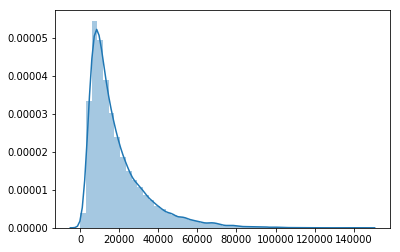

In [18]:
sns.distplot([len(article) for article in t]);

In [19]:
train = TextList(read_wiki(path/'train.txt'), path=path)
valid = TextList(read_wiki(path/'valid.txt'), path=path)

In [20]:
len(train), len(valid)

(18417, 60)

In [21]:
sd = SplitData(train, valid)

In [22]:
proc_tok,proc_num = TokenizeProcessor(max_workers=12),NumericalizeProcessor()

In [23]:
ll = label_by_func(sd, lambda y: 0, proc_x = [proc_tok,proc_num])

In [24]:
pickle.dump(ll, open(path/"ll_wiki.pkl", "wb"))

In [23]:
ll = pickle.load(open(path/"ll_wiki.pkl", "rb"))

In [24]:
bs, bptt = 128, 70
data = lm_databunchify(ll, bs, bptt)

In [25]:
vocab = ll.train.proc_x[-1].vocab

In [26]:
len(vocab)

60002

### Language Model

In [27]:
get_device()

device(type='cuda')

In [28]:
dps = np.array([0.1, 0.15, 0.25, 0.02, 0.2]) * 0.2
tok_pad = vocab.index(PAD)

In [29]:
emb_sz, nh, nl = 400, 1150, 3
model = get_awd_lstm_language_model(len(vocab), emb_sz, nh, nl, tok_pad, *dps)

In [30]:
cbs = [partial(AvgStatsCallback,accuracy_flat),
       partial(CudaCallback, get_device()), 
       Recorder,
       partial(GradientClipping, clip=0.1),
       partial(RNNTrainer, α=2., β=1.),
       ProgressCallback]

In [31]:
#export
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [32]:
#export
def create_scheds(pct_first, sched_func, starts, highs, ends):
    phases = [pct_first, 1-pct_first]
    return [
        combine_scheds(phases, [sched_func(s,h), sched_func(h,e)])
        for s,h,e in zip(starts,highs,ends)
    ]

In [33]:
learn = Learner(model, data, cross_entropy_flat, lr=5e-3, cb_funcs=cbs, opt_func=adam_opt())

In [34]:
lr = 5e-3
sched_lr  = combine_scheds([0.3,0.7], cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.8, 0.7, 0.8))
cbsched = [ParamScheduler('lr', sched_lr), ParamScheduler('mom', sched_mom)]

In [35]:
learn.fit(30, cbs=cbsched)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,4.761940,0.290397,4.180925,0.327922,59:24
1,3.884346,0.352935,3.838163,0.349963,59:27
2,3.581947,0.373871,3.663787,0.361028,59:24
3,3.416202,0.385544,3.584335,0.367068,59:25
4,3.322675,0.391888,3.537614,0.368192,59:20
5,3.267252,0.395393,3.523501,0.369349,59:07
6,3.234434,0.397355,3.512858,0.370809,58:58
7,3.210488,0.398826,3.486179,0.372218,59:07
8,3.187483,0.400536,3.469684,0.374314,59:04
9,3.163123,0.402534,3.461713,0.375657,58:59


In [36]:
torch.save(learn.model.state_dict(), path/'pretrained_large.pth')
pickle.dump(vocab, open(path/'vocab_large.pkl', 'wb'))

In [39]:
warnings

<module 'warnings' from '/home/paperspace/anaconda3/envs/fastai/lib/python3.7/warnings.py'>

In [8]:
path.ls()

[PosixPath('/home/paperspace/.fastai/data/wikitext-103'),
 PosixPath('/home/paperspace/.fastai/data/wikitext-103-v1.zip.1'),
 PosixPath('/home/paperspace/.fastai/data/wikitext-103-v1.zip')]